# Preliminary analysis

In [23]:
import numpy as np
import pandas as pd
import re
import json

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/euroleaks/cleaned.csv')
df.head()

,speaker,speech,timestamp,date
0,jeroen dijsselbloem,… of your responses or questions. and can i fi...,1900-01-01 00:00:00,2015-02-24 00:00:00
1,speaker 2,"uh, yes, uh, thank you, jeroen. well, uh, comm...",1900-01-01 00:00:10,2015-02-24 00:00:00
2,michael noonan,michael noonan.,1900-01-01 00:01:27,2015-02-24 00:00:00
3,speaker 2,"uh, it is therefore regrettable that, uh-",1900-01-01 00:01:29,2015-02-24 00:00:00
4,speaker 2,"… that the letter by the minister does not, uh...",1900-01-01 00:01:37,2015-02-24 00:00:00


## word count by speaker

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer() # does tokenization under the hood
X = vectorizer.fit_transform(df.speech)

df['wordcount'] = X.toarray().sum(axis=1)

wc_by_speaker = df.groupby('speaker')['wordcount'].sum()

In [15]:
wc_by_speaker.describe(percentiles=[.25,.5,.75,.9,.95,.99])

count       61.000000
mean      1430.344262
std       3662.763073
min          5.000000
25%        158.000000
50%        347.000000
75%       1530.000000
90%       2503.000000
95%       3259.000000
99%      19238.600000
max      24002.000000
Name: wordcount, dtype: float64

### all speakers

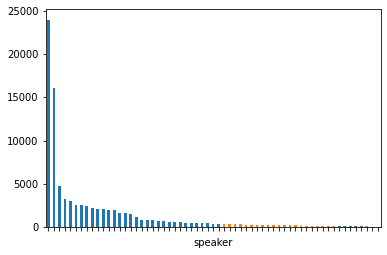

In [16]:
is_named = wc_by_speaker.index.to_series().apply(lambda s: 'speaker' not in s).to_numpy()

cmap = np.array([u'#ff7f0e', u'#1f77b4'])

color = cmap[is_named.astype(int)]

ax = wc_by_speaker.sort_values(ascending=False).plot.bar(color=color)
labels = ax.set_xticklabels([])

### named speakers

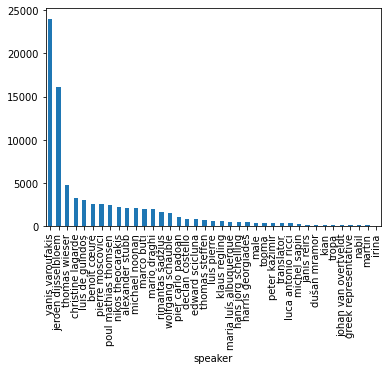

In [18]:
ax = wc_by_speaker[is_named].sort_values(ascending=False).plot.bar()

### unnamed speakers

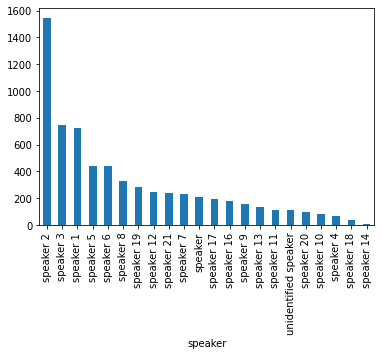

In [19]:
ax = wc_by_speaker[np.invert(is_named)].sort_values(ascending=False).plot.bar()

### proportion of unnamed speakers

In [20]:
x = wc_by_speaker[np.invert(is_named)].sum() / wc_by_speaker.sum()

print(f'{np.round(x*100,4)} % of words belong to unnamed speakers.')

7.5976 % of words belong to unnamed speakers.


## word count by entity

In [24]:
with open('../data/euroleaks/name_to_entity.json', 'r') as f:
    speaker_to_entity = json.load(f)

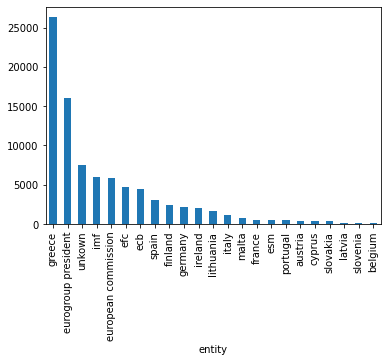

In [26]:
# add column for entity, label unassigned as unknown
df['entity'] = df.speaker.apply(lambda s: speaker_to_entity[s] if s in speaker_to_entity.keys() else 'unkown')

wc_by_entity = df.groupby('entity')['wordcount'].sum()

_ = wc_by_entity.sort_values(ascending=False).plot.bar()

### group institutions together

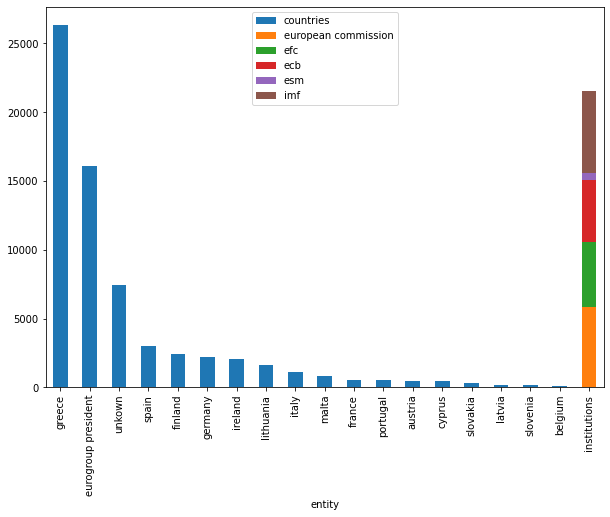

In [27]:
wcent = pd.DataFrame({
    'total': wc_by_entity,
    'countries': wc_by_entity,
    'european commission': np.zeros(wc_by_entity.size, dtype=int),
    'efc': np.zeros(wc_by_entity.size, dtype=int),
    'ecb': np.zeros(wc_by_entity.size, dtype=int),
    'esm': np.zeros(wc_by_entity.size, dtype=int),
    'imf': np.zeros(wc_by_entity.size, dtype=int)
})

wcent.loc['institutions'] = np.array([
    0,
    0,
    wc_by_entity.loc['european commission'],
    wc_by_entity.loc['efc'],
    wc_by_entity.loc['ecb'],
    wc_by_entity.loc['esm'],
    wc_by_entity.loc['imf']
])

wcent['countries'][(wcent.index.to_numpy() == 'efc') | (wcent.index.to_numpy() == 'ecb') | (wcent.index.to_numpy() == 'esm') |(wcent.index.to_numpy() == 'imf') | (wcent.index.to_numpy() == 'european commission')] = 0

_ = wcent.sort_values(by='total', ascending=False).drop(columns=['total'], index=['european commission', 'efc', 'ecb', 'esm', 'imf']).plot.bar(stacked=True, figsize=(10,7))

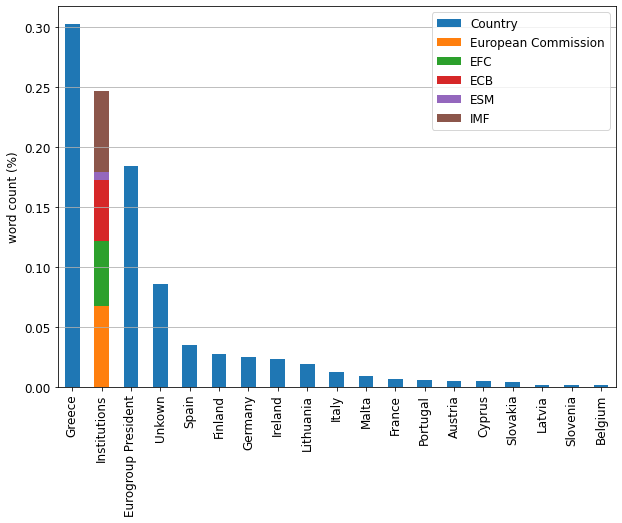

In [59]:
#plt.rcParams.update({'font.size': 12})

# sort descendingly
df_to_plot = wcent.sort_values(by='total', ascending=False).drop(columns=['total'], index=['european commission', 'efc', 'ecb', 'esm', 'imf'])

# make fractions
df_to_plot /= np.repeat(df_to_plot.sum().sum(), df_to_plot.shape[0]*df_to_plot.shape[1]).reshape(df_to_plot.shape)

# rename columns so that legend is ok
df_to_plot.columns = ['Country', 'European Commission', 'EFC', 'ECB', 'ESM', 'IMF']

# reorder and plot bars
df_to_plot.iloc[[0,-1,]+list(range(1,18))].plot.bar(stacked=True, figsize=(10,7))

ax = plt.gca()

ax.set_ylabel('word count (%)')
ax.grid(axis='y')
#ax.set_title('Wordcount by entity')
_ = ax.set_xticklabels(df_to_plot.index.to_series().iloc[[0,-1,]+list(range(1,18))].apply(lambda s: s.title()), rotation=90)
ax.set_xlabel('')

plt.savefig('../figures/wordcound_by_entity.png')